In [1]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt



# Cruide Oil WTI 

## 7:3

In [2]:
df= pd.read_csv('../dataset/Crude Oil.csv')
df = df.dropna() # Drop missing values


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [3]:
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1294 entries, 2 to 1383
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1294 non-null   datetime64[ns]
 1   Price     1294 non-null   float64       
 2   Open      1294 non-null   float64       
 3   High      1294 non-null   float64       
 4   Low       1294 non-null   float64       
 5   Vol.      1294 non-null   int64         
 6   Change %  1294 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 80.9 KB


In [5]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-03-25,81.95,80.85,82.48,80.59,300360,1.64
1,2024-03-22,80.63,80.84,81.45,80.42,231100,-0.54
2,2024-03-21,81.07,81.49,81.92,80.30,266860,-0.75
3,2024-03-20,81.68,83.20,83.21,81.44,26040,-2.14
4,2024-03-19,83.47,82.85,83.85,82.39,76810,0.91
...,...,...,...,...,...,...,...
1289,2019-01-08,49.78,48.73,49.95,48.31,765980,2.60
1290,2019-01-07,48.52,48.30,49.79,48.11,819940,1.17
1291,2019-01-04,47.96,46.90,49.22,46.65,817280,1.85
1292,2019-01-03,47.09,46.26,47.49,45.35,788720,1.18


### Train, Test


In [6]:
# Split the data into training, testing, and validation sets
price = df['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Tạo và huấn luyện mô hình

In [7]:
X_train.shape

(875, 30, 1)

In [8]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=500, batch_size=128)   

c:\Users\21521\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.5004
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4977
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5018
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5021 
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5005
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5001 
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5028 
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4957
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5006 
Epoch 10/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5024 
Epoch 11/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4937 
Epoch 12/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5033 
Epoch 13/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5031 
Epoch 14/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4947 
Epoch 15/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5086 
Epoch 16/500
7/7 ━━━

In [9]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [10]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 89.57828981373187
MAPE trên tập test là: 182.59415689605893 %
MDA trên tập test là: 0.8403361344537815 %


In [11]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [12]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1294,-37.630001
1295,-37.630001
1296,-37.630001
1297,-37.630001
1298,-37.589989
1299,-37.475170
1300,-37.449791
1301,-37.407143
1302,-37.367382
1303,-37.333454


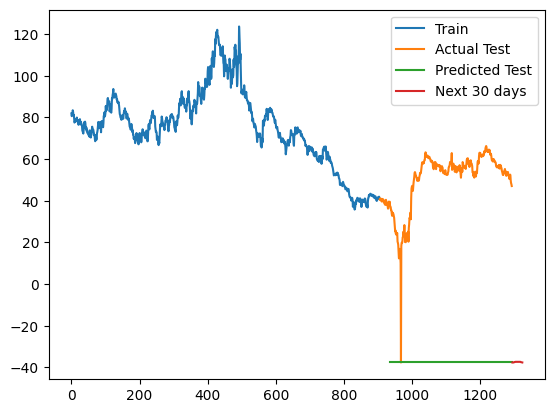

In [13]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()